In [1]:
import galsim
from matplotlib import pyplot as plt
plt.style.use(['dark_background'])
%matplotlib inline

import numpy as np
from SpecklePSF import SpeckleSeries
import pickle
import helperFunctions as helper

### HSM with simulated profiles

In [2]:
galaxy = galsim.Gaussian(flux=1.0, sigma=1.0).shear(g1=.01, g2=.03).drawImage(scale=0.2)

In [3]:
new_params = galsim.hsm.HSMParams(max_amoment=5.0e5, max_mom2_iter=1000)
moments = galsim.hsm.FindAdaptiveMom(galaxy, hsmparams=new_params)

In [4]:
print(f'Error in g1: {abs(.01 - moments.observed_shape.g1)*100:.4f}%')
print(f'Error in g2: {abs(.03 - moments.observed_shape.g2)*100:.4f}%')

Error in g1: 0.0033%
Error in g2: 0.0100%


### HSM on integrated speckles

centroid guess: (122, 143) 
sigma guess: 20.38216560509554


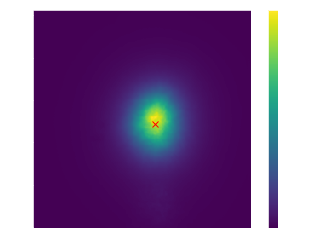

In [44]:
scratchdir = '/global/cscratch1/sd/chebert/'
# this runs the loadMinimalExposures -- so we have 15 accumulated exposures in. 
test = SpeckleSeries('234', 'data', scratchdir)
fullExposure = test.bSeq[-1]

# find first guess of sigma:
comx, comy = helper.imageCOM(fullExposure)
fwhm = helper.imageFWHM(fullExposure, comx, comy)
guestimateSig = fwhm / 2.355
print(f'centroid guess: {comx, comy} \nsigma guess: {guestimateSig}')

# last of the 15 loaded images, so full minute exposure. This has no gain:
plt.imshow(fullExposure, origin='lower')
plt.plot(comy, comx, 'rx')
plt.colorbar()
plt.show()

In [51]:
# make GalSim image of the exposure
fullExpImage = galsim.Image(fullExposure, xmin=0, ymin=0)

# run HSM adaptive moments with initial sigma guess
new_params = galsim.hsm.HSMParams(max_amoment=5.0e8, max_mom2_iter=1000, max_ashift=25)
speckleMoments = galsim.hsm.FindAdaptiveMom(fullExpImage, 
                                            hsmparams=new_params, 
                                            precision=1e-4,
                                            guess_sig=guestimateSig,
                                            guess_centroid=galsim.PositionD(comx, comy))

In [47]:
# tuple of results
speckleMoments.observed_shape.g1, speckleMoments.observed_shape.g2

(-0.10714565488507198, 0.012207228283869003)

### Kolmogorov results for full exposures

In [27]:
kolFits = {'025': {'a': (-0.05690, 0.004082), 'b': (-0.017958, 0.009590)},
           '1262': {'a': (-0.002766, 0.008912), 'b': (-0.027846, 0.023740)},
           '234': {'a': (-0.073403, -0.000138), 'b': (-0.105321, 0.011400)},
           '258': {'a': (-0.013670, -0.012245), 'b': (-0.028969, -0.028505)},
           '484': {'a': (-0.025364, -0.038005), 'b': (0.008507, -0.013954)},
           '663': {'a': (-0.023924, -0.040025), 'b': (-0.016591, -0.012739)},
           '693': {'a': (-0.052389, 0.011534), 'b': (-0.018520, -0.032164)},
           '809': {'a': (0.022332, 0.024677), 'b': (0.028615, 0.018218)},
          }

In [28]:
ag1 = {}
bg1 = {}
ag2 = {}
bg2 = {}
for (k, v) in kolFits.items():
    ag1[k] = v['a'][0]
    bg1[k] = v['b'][0]
    ag2[k] = v['a'][1]
    bg2[k] = v['b'][1]

In [55]:
ag1.keys()

dict_keys(['025', '1262', '234', '258', '484', '663', '693', '809'])

### Find HSM results for these 9 sets:

In [54]:
hsmAg1 = {}
hsmBg1 = {}
hsmAg2 = {}
hsmBg2 = {}

for file in ag1.keys():
    print(file)
    test = SpeckleSeries(file, 'data', scratchdir)

    # find HSM result for filter a
    fullExposure = test.aSeq[-1]
    comx, comy = helper.imageCOM(fullExposure)
    fwhm = helper.imageFWHM(fullExposure, comx, comy)
    guestimateSig = fwhm / 2.355

    new_params = galsim.hsm.HSMParams(max_amoment=5.0e5, max_ashift=75)
    fullExpImage = galsim.Image(fullExposure, xmin=0, ymin=0)
    speckleMoments = galsim.hsm.FindAdaptiveMom(fullExpImage, hsmparams=new_params,
                                                guess_sig=guestimateSig,
                                                guess_centroid=galsim.PositionD(comx, comy))
    hsmAg1[file] = speckleMoments.observed_shape.g1
    hsmAg2[file] = speckleMoments.observed_shape.g2
    
    # find HSM result for filter b
    fullExposure = test.bSeq[-1]
    comx, comy = helper.imageCOM(fullExposure)
    fwhm = helper.imageFWHM(fullExposure, comx, comy)
    guestimateSig = fwhm / 2.355

    fullExpImage = galsim.Image(fullExposure, xmin=0, ymin=0)
    speckleMoments = galsim.hsm.FindAdaptiveMom(fullExpImage, hsmparams=new_params, 
                                                guess_sig=guestimateSig)
    hsmBg1[file] = speckleMoments.observed_shape.g1
    hsmBg2[file] = speckleMoments.observed_shape.g2

025
1262
234
258
484
663
693
809


Only four of nine datasets cooperated with HSM for the full exposure images -- not sure yet why this is, but the comparison below is thus just with four different full-length exposures.

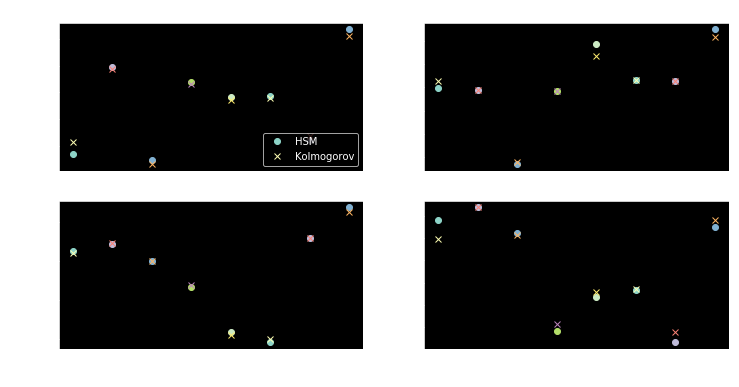

In [56]:
plt.figure(figsize=(12,6))
plt.subplot(221)
i = 0
for (k,v) in hsmAg1.items():
    plt.plot(i, v, 'o', label='HSM')
    plt.plot(i, ag1[k], 'x', label='Kolmogorov')
    if i==0:
        plt.legend(loc=4)
    i += 1
plt.title('a filter')
plt.ylabel('g1')
    
plt.subplot(222)
i = 0
for (k,v) in hsmBg1.items():
    plt.plot(i, v, 'o', label='HSM')
    plt.plot(i, bg1[k], 'x', label='Kolmogorov')
    i += 1
plt.title('b filter')
plt.ylabel('g1')

plt.subplot(223)
i = 0
for (k,v) in hsmAg2.items():
    plt.plot(i, v, 'o', label='HSM')
    plt.plot(i, ag2[k], 'x', label='Kolmogorov')
    i += 1
plt.ylabel('g2')
plt.xlabel('data set') 

plt.subplot(224)
i = 0
for (k,v) in hsmBg2.items():
    plt.plot(i, v, 'o', label='HSM')
    plt.plot(i, bg2[k], 'x', label='Kolmogorov')
    i += 1
plt.ylabel('g2')
plt.xlabel('data set')
plt.show()

All fairly similar to Kolmogorov fits -- should be interesting to see whether this sticks around for shorter exposure too. This is sort of a test of how much I trust the Kolmogorov fits! Although I still don't quite understand how they differ 

### Try HSM on shorter exposures

In [ ]:
scratchdir = '/global/cscratch1/sd/chebert/'
# this runs the loadMinimalExposures -- so we have 15 accumulated exposures in. 
test = SpeckleSeries('809', 'data', scratchdir)

In [ ]:
fullExposure = test.bSeq[8]
# find first guess of sigma:
comx, comy = helper.imageCOM(fullExposure)
fwhm = helper.imageFWHM(fullExposure, comx, comy)
guestimateSig = fwhm / 2.355
print(f'centroid guess: {comx, comy} \nsigma guess: {guestimateSig}')

# last of the 15 loaded images, so full minute exposure. This has no gain:
plt.imshow(fullExposure*test.gain['a'], origin='lower')
plt.plot(comy, comx, 'rx')
plt.colorbar()
plt.show()

# make GalSim image of the exposure
new_params = galsim.hsm.HSMParams(max_amoment=5.0e5, max_mom2_iter=10000)

fullExpImage = galsim.Image(fullExposure, xmin=0, ymin=0)
# run HSM adaptive moments with initial sigma guess
speckleMoments = galsim.hsm.FindAdaptiveMom(fullExpImage, hsmparams=new_params, 
                                            guess_sig=guestimateSig,
                                            guess_centroid=galsim.PositionD(comx, comy))

# tuple of results
speckleMoments.observed_shape.g1, speckleMoments.observed_shape.g2

Log:

**file '025'**
- filter a: They all work, but have nothing to do with Kolmogorov -- much smaller values of g.
- filter b: first two accumulated images fail, but the third works -- and seems roughly consistent with Kolmogorov. Then 4 and 5 fail, and then it works again -- seemingly same general trends as the Kolmogorov fits.

**file '258'**
- filter a: first five fail. Then it starts working, but again, so much smaller values of g
- filter b: They all work, and again miraculously consistent

**file '484'**
- filter a: works, all super tiny.
- filter b: all failed for some reason, even though the last one definitely ran in a previous cell...

**file '809'**
- filter a: work, suprise, super tiny.
- filter b: starts working at index 9, mostly consistent

So what's the deal? Conclusion is that I really need to figure out how to run HSM on more data sets, or else it is not going to be useful to me (or anyone??).
Perhaps spatially binning data would help??
